In [ ]:
with open('prepareddata.txt', 'r') as fh:
  text=fh.read()
  words = text.split(' ')

In [ ]:
import pandas as pd

In [ ]:
# from collections import Counter
# import numpy as np
# import matplotlib.pyplot as plt

# word_list = words

# counts = Counter(word_list)

# labels, values = zip(*counts.items())

# # sort your values in descending order
# indSort = np.argsort(values)[::-1]

# # rearrange your data
# labels = np.array(labels)[indSort]
# values = np.array(values)[indSort]

# indexes = np.arange(len(labels))

# bar_width = 0.35

# plt.bar(indexes, values)

# # add labels
# plt.xticks(indexes + bar_width, labels)
# plt.show()

In [ ]:
import matplotlib.pylab as plt
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
counts = Counter(words)


myList = [k for k, v in counts.items() if v > 1]

counts = Counter(myList)
len(myList)

94568

In [ ]:
# myList

In [ ]:
# plt.rcParams['figure.figsize'] = [50, 10]
# plt.bar(*zip(*counts.most_common()), width=.5, color='g')

In [ ]:
!pip install -q tqdm

In [ ]:
import io
import itertools
import numpy as np
import os
import re
import string
import tensorflow as tf
import tqdm

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Dot, Embedding, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
SEED = 42
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
sentence = "The wide road shimmered in the hot sun"
tokens = list(sentence.lower().split())
print(len(tokens))

8


In [ ]:
# Creating a vocabulary to save mappings from tokens to integer indicies

vocab, index = {}, 1 # --> index starts from 1
vocab['<pad>'] = 0   # --> add a padding token

for token in tokens:
  if token not in vocab:
    vocab[token] = index
    index = index + 1

vocab_size = len(vocab)
print(vocab)

inverse_vocab = {index: token for token, index in vocab.items()}
print(inverse_vocab)
# Vectorizing the sentence
example_sequence = [vocab[word] for word in tokens]
print(example_sequence)

{'<pad>': 0, 'the': 1, 'wide': 2, 'road': 3, 'shimmered': 4, 'in': 5, 'hot': 6, 'sun': 7}
{0: '<pad>', 1: 'the', 2: 'wide', 3: 'road', 4: 'shimmered', 5: 'in', 6: 'hot', 7: 'sun'}
[1, 2, 3, 4, 5, 1, 6, 7]


In [ ]:
# Generate skip-grams from one sentence
# +Positive skip-grams
window_size = 2
positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
    sequence = example_sequence,
    vocabulary_size = vocab_size,
    window_size = window_size,
    negative_samples = 0
)

print(len(positive_skip_grams))
# Let's look at some positive skip-grams
for target, context in positive_skip_grams[0:5]:
  print(f"({target}, {context}): ({inverse_vocab[target]}, {inverse_vocab[context]})")

26
(1, 6): (the, hot)
(5, 3): (in, road)
(2, 1): (wide, the)
(4, 3): (shimmered, road)
(7, 1): (sun, the)


In [ ]:
# SETP0 -Negative skip-gram sampling
# For creating this, we need to sample random words from the vocabulary.
target_word, context_word = positive_skip_grams[0]

# Setting the number of negative samples per positive context.
num_ns = 4

context_class = tf.reshape(tf.constant(context_word, dtype="int64"), (1, 1))
negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
    true_classes = context_class, # class, that should be sampled as 'positive'
    num_true = 1, # each positive skip-gram has 1 positive context class
    num_sampled = num_ns, # number of negative context words to sample
    unique = True,  # all the negative samples should be unique
    range_max = vocab_size, # pick the index of the samples from [0, vocab_size]
    seed = SEED, # seed for reproducibility
    name = "negative_sampling" # the name of this operation
)

print(negative_sampling_candidates)
print([inverse_vocab[index.numpy()] for index in negative_sampling_candidates])


# STEP 1 -Negative skip-gram sampling
# Constructing one training example

# So this is what they claim:
# For a given positive (target_word, context_word) skip-gram, we now also have num_ns negative
# samplex context words, that do not appear in the window size neighborhood of target_word

# ---
# Add a dimension so we can use concatenation (on the next step).
negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)
# Concat positive context word with negative sampled words.
context = tf.concat([context_class, negative_sampling_candidates], 0)
# Label first context word as 1 (positive), followe by num_ns 0s (negative).
label = tf.constant([1] + [0] * num_ns, dtype="int64")

# Reshape target to shape (1,) and context and label to (num_ns+1,).
target = tf.squeeze(target_word)
context = tf.squeeze(context)
label = tf.squeeze(label)

# Now let's look at the beautiful stuff we have created :) ...
print()
print(f"target_index    : {target}")
print(f"target_word     : {inverse_vocab[target_word]}")
print(f"context_indices : {context}")
print(f"context_words   : {[inverse_vocab[c.numpy()] for c in context ]}")
print(f"label           : {label}")



tf.Tensor([2 1 4 3], shape=(4,), dtype=int64)
['wide', 'the', 'shimmered', 'road']

target_index    : 1
target_word     : the
context_indices : [6 2 1 4 3]
context_words   : ['hot', 'wide', 'the', 'shimmered', 'road']
label           : [1 0 0 0 0]


[0.00315225 0.00315225 0.00547597 0.00741556 0.00912817 0.01068435
 0.01212381 0.01347162 0.01474487 0.0159558 ]


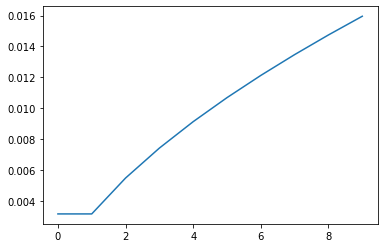

In [ ]:
# Good job!
# Now let's compile all steps into one function! :)

# --- Skip-gram sampling table ---
# Training examples obtained from sampling commonly occuring words, 
# (such as: the, is, on) don't add much useful information for the model to learn from.
# Mikolov et al. suggets subsampling of frequent words as a helpful practice to
# improve embedding quality

# The skipgrams() function accepts a sampling table argument to encode probabilities
# of sampling any token. We can use make_sampling_table() to generate a
# word-frequency rank based probabilistic sampling table and pass it to skipgrams() function

# Let's take a look at the sampling probabilities for a vocab_size of 10
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(size=10)
print(sampling_table)

import matplotlib.pyplot as plt
plt.plot(sampling_table)

# sampling_table[i] denotes the probability of sampling the i-th most common word 
# in a dataset. The function assumes a Zipf's distribution of the word frequencies for sampling.



In [ ]:
# --- Generate training data ---

# Compile all the steps described above into a function that can be called on a list
# of vectorized sentences obtained from any text dataset.
# Notice that the sampling table is built before sampling skip-gram word pairs.
# We will use this function in the later sections.

# The function generates skip-gram pairs with negative sampling for a list of 
# sequencies (int-encoded sentences) based on window size, number of negative samples,
# and vocabulary size

def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for vocab_size tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence, 
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples 
    # with positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1, 
          num_sampled=num_ns, 
          unique=True, 
          range_max=vocab_size, 
          seed=SEED, 
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      negative_sampling_candidates = tf.expand_dims(
          negative_sampling_candidates, 1)

      context = tf.concat([context_class, negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels


In [ ]:
# Prepare training data for Word2Vec
#path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
path_to_file = 'prepareddata.txt'


In [ ]:
print(path_to_file)

prepareddata.txt


In [ ]:
# Read text from the file and take a look at the first few lines.
with open(path_to_file) as f: 
  lines = f.read().splitlines()
for line in lines[:10]:
  print(line)



öcsi az a kisfiú <vesszõ>  aki mindig a porolón "ácsingózik" <vesszõ>  mert onnan messzire lehet látni <pont>
s mert gyakran kapaszkodik fel a porolóra <vesszõ>  azt tartja magáról <vesszõ>  hogy ő egy »világot nézett« gyermek <pont>
valahányszor találkozom vele <vesszõ>  egy <kötõjel> egy történettel áll elő <vesszõ>  és én szó szerint próbálom lejegyezni azokat <pont>
úgyhogy valójában tollbamondások ezek <vesszõ>  noha  <kötõjel>  mint öcsi mondja  <kötõjel>  nekem ahhoz iskolásnak kellene lennem <pont>  <pont>  <pont>
a tegnap már négyéves voltam <vesszõ>  úgyhogy ezután nemcsak gyuri <vesszõ>  a testvérem <vesszõ>  lesz nagy fiú nálunk <vesszõ>  hanem én is <pont>
ha nagyon akarom <vesszõ>  a cipőmet is be tudom kötni <vesszõ>  csak nem mindig sikerül <pont>
de gyurit nem kell megkérni ilyesmire <vesszõ>  mert ő azt mondja <vesszõ>  kínlódjak egy kicsit <vesszõ>  az csak használ <pont>
lehet <vesszõ>  használ neki <vesszõ>  de nekem nem <pont>
most <vesszõ>  hogy négyéves vagyok 

In [ ]:
# Use the non empty lines to construct a TextLineDataset object for next steps
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))

In [ ]:
# Vectorize sentences from the corpus
# You can use the TextVectorization layer to vectorize sentences from the corpus.

# We create a custom standardization function to lowecase the text 
# and remove punctuation.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')
  
# Define the vocabulary size and number of words in a sequence
vocab_size = 32768
sequence_length = 10

# Use the text vectorization layer to normalize, split & map strings to
# integers. Set outpiut_sequence_lenth to pad all samples to the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Call adapt on the text dataset to create vocabulary.
vectorize_layer.adapt(text_ds.batch(1024))

# Once the state of the layer has been adapted to represent the text corpus, the 
# vocabulary can be accessed with get_vocablary()
# This function returns a list of all vocabulary tokens sorted (descenting) 
# by their frequency

# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

# --- o ---
# The vecorize_layer can now be used to generate vectors for each element in the text_ds
def vectorize_text(text):
  text = tf.expand_dims(text, -1)
  return tf.squeeze(vectorize_layer(text))

# Vectorize the data in text_ds
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

# Obtain sequnences from the dataset
# Now we need to flatten it.
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

# --- o ---
# Generate training examples from sequences
targets, contexts, labels = generate_training_data(
    sequences=sequences, 
    window_size=2, 
    num_ns=4, 
    vocab_size=vocab_size, 
    seed=SEED)
print(len(targets), len(contexts), len(labels))

['', '[UNK]', 'vesszõ', 'a', 'pont', 'kötõjel', 'az', 'hogy', 'nem', 's', 'is', 'és', 'egy', 'de', 'kettõspont', 'kérdőjel', 'volt', 'meg', 'csak', 'ha']


  0%|          | 49/190212 [00:00<06:31, 485.33it/s]

190212


100%|██████████| 190212/190212 [08:39<00:00, 366.23it/s]

1135429 1135429 1135429


In [ ]:
# Configure the dataset for performance
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)
# Add cache() and prefetch() to improve performance.
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

# Model and Training
class Word2Vec(Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = Embedding(vocab_size, 
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding", )
    self.context_embedding = Embedding(vocab_size, 
                                       embedding_dim, 
                                       input_length=num_ns+1)
    self.dots = Dot(axes=(3,2))
    self.flatten = Flatten()

  def call(self, pair):
    target, context = pair
    we = self.target_embedding(target)
    ce = self.context_embedding(context)
    dots = self.dots([ce, we])
    return self.flatten(dots)

# Define loss function and compile model
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Also define a callback to log training statistics for tensorboard.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
# Train the model with dataset prepared above for some number of epochs.
word2vec.fit(dataset, epochs=50, callbacks=[tensorboard_callback])

<BatchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>
<PrefetchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>
Epoch 1/50
   1/1108 [..............................] - ETA: 0s - loss: 1.6092 - accuracy: 0.2148WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1108/1108 [==============================] - 77s 70ms/step - loss: 1.4420 - accuracy: 0.4146
Epoch 2/50
1108/1108 [==============================] - 75s 68ms/step - loss: 1.2348 - accuracy: 0.5284
Epoch 3/50
1108/1108 [==============================] - 75s 68ms/step - loss: 1.0711 - accuracy: 0.6128
Epoch 4/50
1108/1108 [==============================] - 75s 68ms/step - loss: 0.9199 - accuracy: 0.6800
Epoch 5/50
1108

In [ ]:
# Embedding lookup and analysis
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# Create and save the vectors and metadata file.
for index, word in enumerate(vocab):
  if  index == 0: continue # skip 0, it's padding.
  vec = weights[index] 
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

# Download the vectors.tsv and metadata.tsv to analyze the obtained embeddings in the Embedding Projector.
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception as e:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
weights[0, :]

array([ 3.01040709e-04, -4.98955324e-03, -3.00200228e-02,  9.58134979e-03,
        1.46511905e-02,  1.50336958e-02, -8.41033459e-03,  1.82758309e-02,
       -3.41243967e-02,  4.64486592e-02,  8.90988111e-03,  4.15102355e-02,
       -1.27904899e-02, -8.71375948e-03, -2.39573792e-03, -2.46577021e-02,
        3.94037478e-02, -4.28470857e-02, -1.73326135e-02, -2.55941227e-03,
       -3.99748199e-02, -2.61242148e-02, -4.99115847e-02, -3.02686580e-02,
       -1.08409524e-02,  4.07766216e-02,  3.07459347e-02, -2.81380173e-02,
       -1.08834282e-02, -3.17713022e-02,  4.44571488e-02,  4.97411527e-02,
        1.42037310e-02,  4.46783416e-02, -9.88741964e-03,  2.23725103e-02,
       -3.62077244e-02, -1.96780562e-02, -5.03738970e-03, -2.12438107e-02,
        1.75194480e-02,  2.66864337e-02, -1.53160580e-02,  3.58392335e-02,
        1.96385048e-02, -3.16422209e-02, -3.65297906e-02, -8.57895613e-03,
       -2.52041966e-03,  3.85163315e-02, -4.82419133e-02, -4.26784903e-03,
        4.31840904e-02,  

In [ ]:
print(weights)
print(vocab)

[[ 3.0104071e-04 -4.9895532e-03 -3.0020023e-02 ... -3.0248702e-02
   3.6813345e-02  1.5281390e-02]
 [-1.1917211e-01 -6.5195173e-01 -9.2206484e-01 ...  3.0458447e-01
  -4.8130408e-01 -1.5569502e-01]
 [-2.0109603e-01 -2.4046429e-01 -6.5340333e-02 ... -1.1493919e-01
   1.3847572e-01  2.9829592e-01]
 ...
 [ 6.9456166e-01 -3.1349671e-01 -4.6060693e-01 ... -5.1625144e-02
   5.1905590e-01 -1.1269541e-01]
 [ 1.0698840e-01 -3.7489113e-01 -1.8865992e-01 ...  4.4964395e-02
   1.0954910e-01  1.0034099e-01]
 [ 5.0848323e-01 -2.4460816e-01  3.3431789e-01 ... -7.6835001e-01
   3.6839291e-01  2.2808252e-01]]
['', '[UNK]', 'vesszõ', 'a', 'pont', 'kötõjel', 'az', 'hogy', 'nem', 's', 'is', 'és', 'egy', 'de', 'kettõspont', 'kérdőjel', 'volt', 'meg', 'csak', 'ha', 'sem', 'még', 'már', 'azt', 'ez', 'én', 'el', 'nagy', 'úgy', 'van', 'hát', 'volna', 'mert', 'mint', 'ki', 'most', 'e', 'mondta', 'ott', 'aztán', 'mi', 'király', 'két', 'te', 'mit', 'olyan', 'ezt', 'ő', 'akkor', 'vagy', 'itt', 'ne', 'majd', 'jó', 